# 1.Project Overview

Mchezopesa Ltd and tasked to accomplish the task below. A prediction result of a game between team 1 and team 2, based on who's home and who's away, and on whether or not the game is friendly (include rank in your training). You have two possible approaches (as shown below) given the datasets that will be provided


# **2. ObJective**

By the end of the project I should have created a model that is able to predict if A team will win, lose or draw a match, given the  ranking of the home and away team, the home team  and away team

# 3.Data understanding

In [107]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
import datetime as dt

In [58]:
## import our datas
df_ranking=pd.read_csv('/content/fifa_ranking.csv')
df_result=pd.read_csv('/content/results.csv')

In [59]:
## view the fifa ranking
df_ranking.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [60]:
## view the results
df_result.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [61]:
## data shape
print(df_ranking.shape)
print(df_result.shape )

(57793, 16)
(40839, 9)


In [62]:
### ranking info info
df_ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57793 entries, 0 to 57792
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rank                     57793 non-null  int64  
 1   country_full             57793 non-null  object 
 2   country_abrv             57793 non-null  object 
 3   total_points             57793 non-null  float64
 4   previous_points          57793 non-null  int64  
 5   rank_change              57793 non-null  int64  
 6   cur_year_avg             57793 non-null  float64
 7   cur_year_avg_weighted    57793 non-null  float64
 8   last_year_avg            57793 non-null  float64
 9   last_year_avg_weighted   57793 non-null  float64
 10  two_year_ago_avg         57793 non-null  float64
 11  two_year_ago_weighted    57793 non-null  float64
 12  three_year_ago_avg       57793 non-null  float64
 13  three_year_ago_weighted  57793 non-null  float64
 14  confederation         

In [63]:
### results info
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40839 entries, 0 to 40838
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        40839 non-null  object
 1   home_team   40839 non-null  object
 2   away_team   40839 non-null  object
 3   home_score  40839 non-null  int64 
 4   away_score  40839 non-null  int64 
 5   tournament  40839 non-null  object
 6   city        40839 non-null  object
 7   country     40839 non-null  object
 8   neutral     40839 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.5+ MB


## **4 Data cleaning and Manipulation**

In [64]:
# Changing the date column data type to datetime#

df_ranking['rank_date'] = pd.to_datetime(df_ranking['rank_date'])
df_result['date'] = pd.to_datetime(df_result['date'])

In [65]:
# Create new columns and split the date colums into month and year.
# For the year columns
df_ranking['year'] = df_ranking['rank_date'].dt.year
df_result['year'] = df_result['date'].dt.year

# Now for the month columns
df_ranking['month'] = df_ranking['rank_date'].dt.month
df_result['month'] = df_result['date'].dt.month

In [66]:
# Dropping irrelevant columns in rank dataset
rank = df_ranking.drop(['country_abrv', 'total_points',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted',], axis=1)

results =df_result.drop(['city', 'country' ], axis=1)

In [67]:
rank.head()

,rank,country_full,confederation,rank_date,year,month
0,1,Germany,UEFA,1993-08-08,1993,8
1,2,Italy,UEFA,1993-08-08,1993,8
2,3,Switzerland,UEFA,1993-08-08,1993,8
3,4,Sweden,UEFA,1993-08-08,1993,8
4,5,Argentina,CONMEBOL,1993-08-08,1993,8


In [68]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month
0,1872-11-30,Scotland,England,0,0,Friendly,False,1872,11
1,1873-03-08,England,Scotland,4,2,Friendly,False,1873,3
2,1874-03-07,Scotland,England,2,1,Friendly,False,1874,3
3,1875-03-06,England,Scotland,2,2,Friendly,False,1875,3
4,1876-03-04,Scotland,England,3,0,Friendly,False,1876,3


In [69]:
# Merging the Home Team dataset
home= pd.merge(results, rank,  left_on = ['home_team', 'year', 'month'],right_on = ['country_full', 'year', 'month'],  how = 'inner' )

In [70]:

# Merging the Away Team dataset
away = pd.merge(results, rank, how = 'inner', left_on = ['year', 'month', 'away_team'],right_on = ['year', 'month', 'country_full'])

In [71]:
# Renaming the ranks columns to get the home team and away team ranks
#
home.rename({'rank' : 'home_rank'}, axis = 1, inplace = True)
away.rename({'rank' : 'away_rank'}, axis =1, inplace = True)

In [72]:

away = away[['away_team','away_rank','year','month']]
away.head()

,away_team,away_rank,year,month
0,Paraguay,67,1993,8
1,Paraguay,67,1993,8
2,Argentina,5,1993,8
3,Argentina,5,1993,8
4,Argentina,5,1993,8


In [73]:
### merging the home and away data
df = pd.merge(home,away, how = 'inner', left_on = ['year', 'month', 'away_team'], right_on = ['year', 'month', 'away_team'])

df.head()

,date,home_team,away_team,home_score,away_score,tournament,neutral,year,month,home_rank,country_full,confederation,rank_date,away_rank
0,1993-08-01,Colombia,Paraguay,0,0,FIFA World Cup qualification,False,1993,8,19,Colombia,CONMEBOL,1993-08-08,67
1,1993-08-01,Colombia,Paraguay,0,0,FIFA World Cup qualification,False,1993,8,19,Colombia,CONMEBOL,1993-08-08,67
2,1993-08-29,Argentina,Paraguay,0,0,FIFA World Cup qualification,False,1993,8,5,Argentina,CONMEBOL,1993-08-08,67
3,1993-08-29,Argentina,Paraguay,0,0,FIFA World Cup qualification,False,1993,8,5,Argentina,CONMEBOL,1993-08-08,67
4,1993-08-15,Colombia,Argentina,2,1,FIFA World Cup qualification,False,1993,8,19,Colombia,CONMEBOL,1993-08-08,5


In [74]:
df =df.drop(['date','country_full','rank_date','confederation'], 1)
df.head()

,home_team,away_team,home_score,away_score,tournament,neutral,year,month,home_rank,away_rank
0,Colombia,Paraguay,0,0,FIFA World Cup qualification,False,1993,8,19,67
1,Colombia,Paraguay,0,0,FIFA World Cup qualification,False,1993,8,19,67
2,Argentina,Paraguay,0,0,FIFA World Cup qualification,False,1993,8,5,67
3,Argentina,Paraguay,0,0,FIFA World Cup qualification,False,1993,8,5,67
4,Colombia,Argentina,2,1,FIFA World Cup qualification,False,1993,8,19,5


In [75]:
## rearrange the columns
data=df[['year','home_team','away_team','home_score','away_score','home_rank','away_rank','tournament','neutral']]
data.head()

,year,home_team,away_team,home_score,away_score,home_rank,away_rank,tournament,neutral
0,1993,Colombia,Paraguay,0,0,19,67,FIFA World Cup qualification,False
1,1993,Colombia,Paraguay,0,0,19,67,FIFA World Cup qualification,False
2,1993,Argentina,Paraguay,0,0,5,67,FIFA World Cup qualification,False
3,1993,Argentina,Paraguay,0,0,5,67,FIFA World Cup qualification,False
4,1993,Colombia,Argentina,2,1,19,5,FIFA World Cup qualification,False


In [76]:
### duplicates
data=data.drop_duplicates()

In [77]:
## missing value
data.isnull().sum()

year          0
home_team     0
away_team     0
home_score    0
away_score    0
home_rank     0
away_rank     0
tournament    0
neutral       0
dtype: int64

In [78]:
### creating a goal difference
data['goal_difference']=data['home_score']-data['away_score']

In [79]:
def status(difference):
  if difference> 0:
    return 'Win'
  elif difference < 0:
    return 'Lose'
  else:
    return 'Draw'
# Applying the result function to the dataframe
data['Status'] = data['goal_difference'].apply(lambda x: status(x))

In [80]:
## the final data after cleaning
data.head()

,year,home_team,away_team,home_score,away_score,home_rank,away_rank,tournament,neutral,goal_difference,Status
0,1993,Colombia,Paraguay,0,0,19,67,FIFA World Cup qualification,False,0,Draw
2,1993,Argentina,Paraguay,0,0,5,67,FIFA World Cup qualification,False,0,Draw
4,1993,Colombia,Argentina,2,1,19,5,FIFA World Cup qualification,False,1,Win
7,1993,Peru,Argentina,0,1,70,5,FIFA World Cup qualification,False,-1,Lose
10,1993,Paraguay,Argentina,1,3,67,5,FIFA World Cup qualification,False,-2,Lose


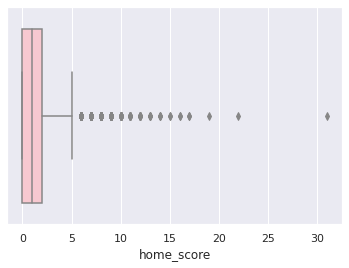

In [81]:
### looking for  outliers in the scores
sns.boxplot(data['home_score'],color='pink')


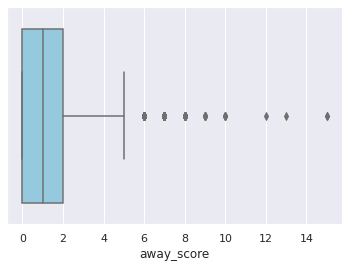

In [82]:
##OUTLIERS 
sns.boxplot(data['away_score'],color='skyblue')
plt.show()

In [83]:
q1=data.quantile(0.25)
q3=data.quantile(0.75)
IQR =q3-q1
data = data[~((data < (q1 - 1.5 * IQR)) |(data > (q3 + 1.5 * IQR))).any(axis=1)]
data.shape
### we have removed our outliers

(12467, 11)

#5. Exploratory data analysis

In [84]:
data.head()

,year,home_team,away_team,home_score,away_score,home_rank,away_rank,tournament,neutral,goal_difference,Status
0,1993,Colombia,Paraguay,0,0,19,67,FIFA World Cup qualification,False,0,Draw
2,1993,Argentina,Paraguay,0,0,5,67,FIFA World Cup qualification,False,0,Draw
4,1993,Colombia,Argentina,2,1,19,5,FIFA World Cup qualification,False,1,Win
7,1993,Peru,Argentina,0,1,70,5,FIFA World Cup qualification,False,-1,Lose
10,1993,Paraguay,Argentina,1,3,67,5,FIFA World Cup qualification,False,-2,Lose


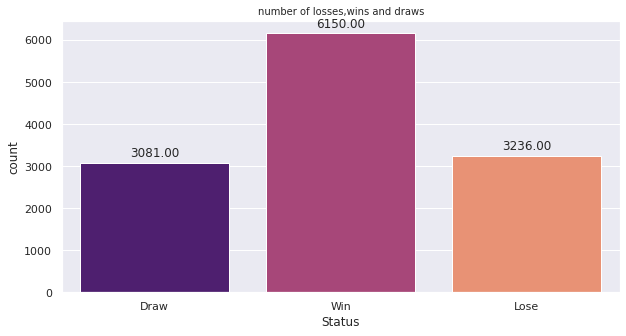

In [85]:
### the number wins and losses
fig, ax= plt.subplots(figsize=(10,5))
sns.set(style="darkgrid")
ax=sns.countplot(data['Status'],palette='magma')
ax.set_title('number of losses,wins and draws',fontsize=(10))
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
              va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [86]:
## statistical description of the data
data[['home_score','away_score']].describe()

,home_score,away_score
count,12467.000000,12467.000000
mean,1.495628,0.981471
std,1.285822,1.083351
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,5.000000,5.000000


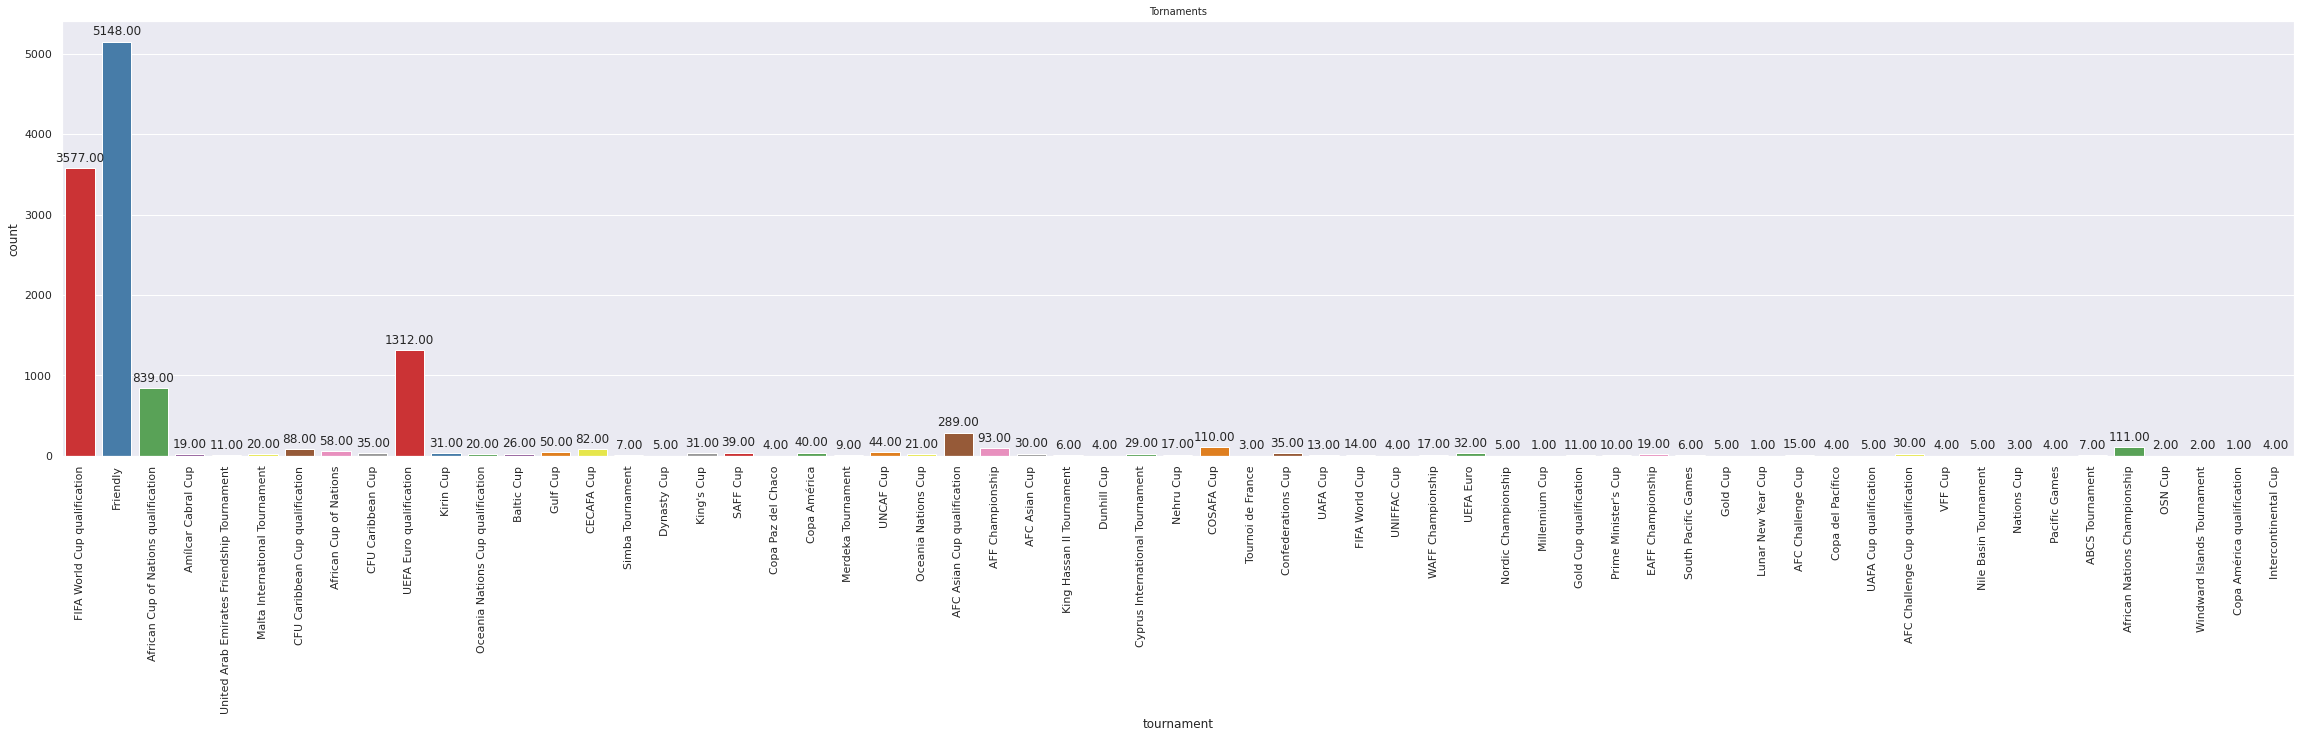

In [87]:
### number of tournment being checked
fig, ax= plt.subplots(figsize=(40 ,8))
sns.set(style="darkgrid")
ax=sns.countplot(data['tournament'],palette='Set1')
ax.set_title('Tornaments',fontsize=(10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
              va = 'center', xytext = (0, 10), textcoords = 'offset points')

From above we most of the matches are friendly(5148) and 3577 fifa world cups and 1312 uefa euro qualifiers.

In [88]:
#### label encoding
ll=LabelEncoder()
data['away_team']=ll.fit_transform(data['away_team'])
data['home_team']=ll.fit_transform(data['home_team'])
data['tournament']=ll.fit_transform(data['tournament'])
data['neutral']=ll.fit_transform(data['neutral'])
data['Status']=ll.fit_transform(data['Status'])


In [89]:
data.head(2)

,year,home_team,away_team,home_score,away_score,home_rank,away_rank,tournament,neutral,goal_difference,Status
0,1993,40,137,0,0,19,67,25,0,0,0
2,1993,7,137,0,0,5,67,25,0,0,0


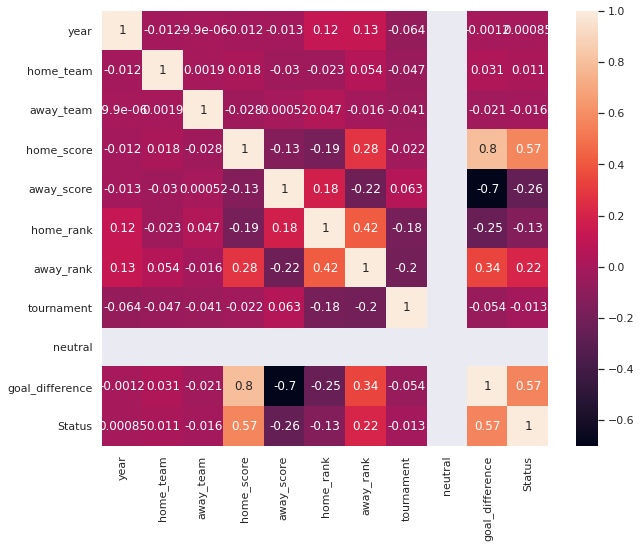

In [90]:
## plotting a heatmap to show correlation
fig,ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(data.corr(),annot=True,)

# 6. Predictive analysis

In [94]:
## diviving oour data into features and labels
x=data[['home_team',	'away_team',	'home_score',	'away_score',	'tournament', 'home_rank', 'away_rank']]
y=data['Status'].values

In [96]:
### correlation of the features
correlations=x.corr()
correlations

,home_team,away_team,home_score,away_score,tournament,home_rank,away_rank
home_team,1.000000,0.001941,0.017582,-0.029628,-0.047171,-0.023366,0.054287
away_team,0.001941,1.000000,-0.028450,0.000522,-0.040564,0.047136,-0.016265
home_score,0.017582,-0.028450,1.000000,-0.131442,-0.022493,-0.188433,0.280999
away_score,-0.029628,0.000522,-0.131442,1.000000,0.063108,0.181564,-0.224366
tournament,-0.047171,-0.040564,-0.022493,0.063108,1.000000,-0.182777,-0.196273
home_rank,-0.023366,0.047136,-0.188433,0.181564,-0.182777,1.000000,0.419963
away_rank,0.054287,-0.016265,0.280999,-0.224366,-0.196273,0.419963,1.000000


In [97]:
##Checking multi colinearity
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)

,home_team,away_team,home_score,away_score,tournament,home_rank,away_rank
home_team,1.007765,-0.004202,0.018836,-0.001265,0.044736,0.069643,-0.080821
away_team,-0.004202,1.005749,0.003931,0.022368,0.037986,-0.067534,0.056318
home_score,0.018836,0.003931,1.241664,-0.050021,0.009883,0.480728,-0.561036
away_score,-0.001265,0.022368,-0.050021,1.172946,-0.064511,-0.420764,0.441702
tournament,0.044736,0.037986,0.009883,-0.064511,1.060565,0.154514,0.124208
home_rank,0.069643,-0.067534,0.480728,-0.420764,0.154514,1.561042,-0.859622
away_rank,-0.080821,0.056318,-0.561036,0.441702,0.124208,-0.859622,1.647446


All the variables are below 5 hence have love multicoll

In [117]:

# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 124)

# Standardising the X_train and the X_test to the same scale
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Fitting the polynomial features to the X_train and X_test
poly_features = PolynomialFeatures(degree = 1)
x_train = poly_features.fit_transform(x_train)
x_test = poly_features.fit_transform(x_test)

# Training the model
model= LinearRegression()
model.fit(x_train, y_train)

# Making predictions
y_pred=model.predict(x_test)

In [112]:
# Creating a parameters dictionary
#
params = {'normalize': [True, False],
         'fit_intercept': [True, False]}

# Creating a cross validation of 5 folds
#
kfold = KFold(n_splits = 5)

# Using grid search to find the optimal parameters
grid_search = GridSearchCV(estimator=regressor, param_grid = params, cv = kfold)

# Fitting the grid search 
grid_search_results = grid_search.fit(x, y)

# Displaying the best parameters and the the best score
print(f'Best score is {grid_search.best_score_}')

Best score is 0.35892095737366364


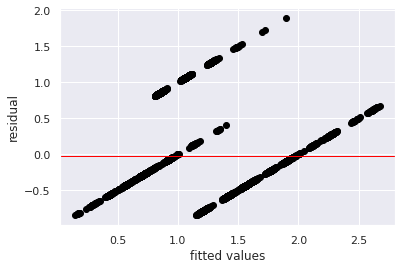

In [118]:
 #Plotting the residual plot
# Residuals have been calculated by by substracting the test value from the predicted value
residuals = np.subtract(y_pred, y_test)

# Plotting the residual scatterplot
plt.scatter(y_pred, residuals, color='black')
plt.ylabel('residual')
plt.xlabel('fitted values')
plt.axhline(y= residuals.mean(), color='red', linewidth=1)
plt.show()

In [119]:
# Performing the barlett's test
import scipy as sp
test, pvalue = sp.stats.bartlett(y_pred, residuals)

In [122]:
# Calculating the critical value of the chi squared distribution, to compare it with the test_result
degrees_of_freedom = len(y_pred) - 1
probability =  1 - pvalue
critical_value = sp.stats.chi2.ppf(probability, degrees_of_freedom)

if (test > critical_value):
  print('The variances are heterogenous')
else:  
  print('The variances are homogeneous')

The variances are homogeneous
